## Importing all the modules needed and API tools used

In [1]:
import requests
import json
from IPython.display import HTML, display, Image
import bs4
import pandas as pd
import numpy as np
from numpy import *
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
from scipy.interpolate import *
import warnings
warnings.filterwarnings("ignore") 

In [2]:
with open('./Data/Day6-Web-Scraping/us_state_names.json') as file_in:
    states_w_codes = json.load( file_in )
    
with open('./Data/Day6-Web-Scraping/us_state_city_names.json') as file_in:
    cities_by_state = json.load( file_in )

In [3]:
auth = {}
with open('./census_auth.json', 'w') as file_out:
    json.dump(auth, file_out)

with open('census_auth.json', 'r') as file_in:
    auth = json.load(file_in)

auth['my_key'] = 'ca71b8e2ccc50ee306a24320bf06fc8f505f3f79'

census_url = 'http://api.census.gov/data/2010/dec/sf1?'

## Defining codes and categories to be used

In [4]:
# Defining the race categories I'm using (for labeling purposes when I make the graphs)
races = ['Total' , 'White', 'Black', 
         'Native', 'Asian', 'Hawaiian', 
         'Other', 'Two or More', 'Hispanic']

# Defining the corresponding codes for the race categories above, both total populations and institutionalized populations
codes = ['P029027','P003001', 'P029I027','P005003', 'P029B027',
         'P003003', 'P029C027','P003004', 'P029D027','P003005', 
         'P029E027','P003006', 'P029F027','P003007', 
         'P029G027','P003008', 'P029H027','P004003']

# Dictionary to know what code I'm using, also used for labeling purposes
code_to_title = {'P029027':'Total in Prison','P003001':'Total', 'P029I027':'White in Prison','P005003':'Total White', 
                 'P029B027':'Black in Prison','P003003':'Total Black', 'P029C027':'Native in Prison','P003004':'Total Native', 
                 'P029D027':'Asian in Prison','P003005':'Total Asian', 'P029E027':'Hawaiian in Prison','P003006':'Total Hawaiian', 
                 'P029F027':'Other in Prison','P003007':'Total Other', 'P029G027':'Two or More in Prison','P003008':'Total Two or More', 
                 'P029H027':'Hispanic in Prison','P004003':'Total Hispanic'}

## Gathering data and calculating population fractions

In [5]:
# Define datacodes to be used in request
data_codes = ''
for code in codes:
    data_codes += code + ','
data_codes += 'NAME'

# Define dataframes into which data is going to be input for future analysis
all_absolute_data = pd.DataFrame(columns=codes).rename(columns=code_to_title)
all_fractional_data = pd.DataFrame(columns=codes).rename(columns=code_to_title)

# Setting up for loop to go through each state and gather data
for key in states_w_codes.keys():
    # Define state parameter for API calling function
    state_fips = 'state:' + states_w_codes[key]['fips_state']
    # Executing API calling function
    response = requests.get(census_url, params = {'key': auth['my_key'], 'get': data_codes, 'for': state_fips})
    datapoint = json.loads(response.text)
    
    # Gather the data we want one of them will be appended as is to its dataframe, the other (fractional) will be modified
    absolute_state_population = pd.DataFrame(datapoint[1:], columns = datapoint[0]).rename(columns=code_to_title)
    fractional_state_population = pd.DataFrame(datapoint[1:], columns = datapoint[0]).rename(columns=code_to_title)
    
    # Modify fractional state population so that it represents fractional population values as opposed to absolute populations
    # This is done by dividing each race's prison population by the total prison population and dividing the general race's
    # population by the total general population
    for race in races:
        if race != 'Total':
            fractional_state_population.ix[0,race + ' in Prison'] = int(absolute_state_population.ix[0,race + ' in Prison'])/int(absolute_state_population.ix[0,'Total in Prison'])
            fractional_state_population.ix[0,'Total ' + race] = int(absolute_state_population.ix[0,'Total ' + race])/int(absolute_state_population.ix[0,'Total'])
        else: # We don't want it to look for the index 'Total Total' so we have a separate line of code for that index
            fractional_state_population.ix[0,'Total in Prison'] = int(absolute_state_population.ix[0,'Total in Prison'])/int(absolute_state_population.ix[0,'Total in Prison'])
            fractional_state_population.ix[0,'Total'] = int(absolute_state_population.ix[0,'Total'])/int(absolute_state_population.ix[0,'Total'])
    
    # Append the datapoints we just extracted for that state to the dataframe containing all the states' data
    # This is what we extract data from when we plot our graphs
    all_absolute_data = all_absolute_data.append(absolute_state_population)
    all_fractional_data = all_fractional_data.append(fractional_state_population)


## Plot three graphs representing the relationship between the fraction of the total population occupied by each race and the fraction of the prison population occupied by them

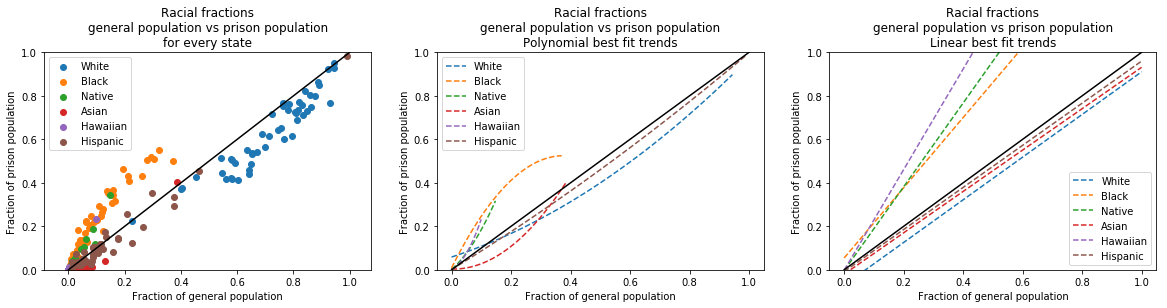

In [11]:
#### Define the three plots we are going to fill and present #####

# plotting the individual data points for each state
points = plt.subplot(1,3, 1)
plt.title('Racial fractions\ngeneral population vs prison population\nfor every state')

# Plot the trend for each race as fit by a second order polynomial
polynomial_trends = plt.subplot(1,3, 2)
plt.title('Racial fractions\ngeneral population vs prison population\nPolynomial best fit trends')

# Plot the trends for each race as fit by a linear best fit line
linear_trends = plt.subplot(1,3, 3)
plt.title('Racial fractions\ngeneral population vs prison population\nLinear best fit trends')

##### Plot the data for each race in the appropriate way onto the three plots above #####
for race in races:
    if race != 'Total' and race != 'Two or More' and race != 'Other':
        x = all_fractional_data.ix[:,'Total ' + race]
        y = all_fractional_data.ix[:,race + ' in Prison']
        
        # datapoints for each state
        points.scatter(x,y)
        
        # second order polynomial best fit
        axis_range = linspace(0,max(x)) # This is the x-axis data used to model the trend lines
        poly_coefs = polyfit(np.float32(x), np.float32(y), deg=2)
        polynomial_trends.plot(axis_range, polyval(poly_coefs,axis_range),'--')
        
        # linear best fit
        axis_range = linspace(0,1) # This is the x-axis data used to model the trend lines
        linear_coefs = polyfit(np.float32(x), np.float32(y), deg=1)
        linear_trends.plot(axis_range, polyval(linear_coefs,axis_range),'--')

# if a racial category wasn't plotted, remove it from the legend
unwanted_in_legend = {'Total','Two or More','Other'}
plot_legend = [race for race in races if race not in unwanted_in_legend]

# Add decoration and labeling for subplots
for graph in [points, polynomial_trends, linear_trends]:
    graph.legend(plot_legend)
    graph.plot([0,1],[0,1],'black')
    graph.set_ylim([0,1])
    graph.set_xlabel('Fraction of general population')
    graph.set_ylabel('Fraction of prison population')
    
# make sure there's enough space between graphs and plot
plt.subplots_adjust(right=2.7)
plt.show()


## The line of no racial bias and what it means to be above or below it
* Black diagonal line is the X=Y line, representing the relationship between racial fraction in general population vs prison population assuming no racial bias in judicial system.
* Looking at linear trendlines, we see that there prison populations are disproportionate. We can divide racial groups into two main types
    * Those that are consistently overrepresented in prison populations and lie above the X=Y line (Native American, Black and Native Hawaiian)
    * Those that are underrepresented and lie below the X=Y line, but less severely so than those that are overrepresented (White, Asian and Hispanic)

## Difficulty of extrapolation and how to improve data
* It is difficult to extrapolate for any population beyond white because we do not have data for them as majority populations. This is because we looked at data on the state level. This is also why the analysis would benefit from using data on the level of what individual police departments are responsible for, as opposed to entire states. Doing this would allow for more datapoints in which each one of the racial groups is both a minority and a majority population, allowing for more accurate captuing of trends along the spectrum

## What does the data mean
* We should analyze this with consideration for the average income of these respective groups:
    * White, Asian and Hispanic populations have average annual incomes of 60k, 80k and 50k USD respectively
    * Native American, Native Hawaiian and Black populations have average annual incomes of 39k, 55k and 38k USD respectively
* Although native Hawaiians have a higher average income than hispanics, they are concentrated in states with much higher living prices (e.g. in Hawaii, anything below 84k USD annually is considered low income)

## Possible explanation
* As such, a reasonable explanation for the disproprotionality in criminal populations is the disproportionality in income levels, which is well documented to link to both increased interrogation from the police, lower likelihood of being able to afford good lawyers as well as increased crime levels to begin with.
* It is significant that the three poorer populations (black, native american and native hawaiian) are all groups that have lived in the US for more generations (more asians and latinos in the US moved here in the 1900s; selection for immigration is biased in favor of the educated and wealthy, skewing the results).

## Trends as the fraction of general population increases for any race

* Looking at the second order best fits, we can see that for black and asian americans, who were over and underrepresented in prison populations respectively, there seems to be a decrease in the degree of disproportionality as they become a larger fraction of the population (their trends curve towards the X=Y line, this offers potential evidence for the idea that exposure to an ethnic minority can lead to a decrease in the internalization of stereotypes/bias (i.e less likely to think that black people are thugs and asians are docile --> more likely to interrogate and inspect cases proportionately). However, the evidence for this extrapolation is not strong as most of the datapoints for these minorities are clustered near the bottom of the spectrum and cannot be extrapolated reasonably.